```
Topic:        Project 1
Subject:      Explore MTA turnstile data
Date:         07/06/2020
Name:         David Weon
Worked with:  Adam Rauckhorst, Dyllan Usher
```

In [1]:
import pandas as pd
csvs = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt',
        'http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt']
df = pd.concat((pd.read_csv(csv) for csv in csvs))

In [2]:
df.reset_index(inplace=True)

In [3]:
df.columns = [column.strip() for column in df.columns]

In [4]:
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], format="%m/%d/%Y %H:%M:%S")
df

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,2019-05-25 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415,2019-05-25 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443,2019-05-25 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500,2019-05-25 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555,2019-05-25 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233256,208676,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/17/2019,01:00:00,REGULAR,5554,376,2019-05-17 01:00:00
1233257,208677,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/17/2019,05:00:00,REGULAR,5554,376,2019-05-17 05:00:00
1233258,208678,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/17/2019,09:00:00,REGULAR,5554,376,2019-05-17 09:00:00
1233259,208679,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/17/2019,17:00:00,REGULAR,5554,376,2019-05-17 17:00:00


In [5]:
#checking for duplicates
(df
.groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
.ENTRIES.count()
.reset_index()
.sort_values("ENTRIES", ascending=False)
.head(20))

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
870892,R174,R034,00-00-02,125 ST,2019-06-08 00:00:00,2
612865,N525,R142,01-00-04,DELANCEY/ESSEX,2019-05-11 05:00:00,2
291196,N045,R187,01-00-02,81 ST-MUSEUM,2019-06-01 17:00:00,2
291507,N045,R187,01-06-00,81 ST-MUSEUM,2019-06-11 21:00:00,2
291201,N045,R187,01-00-02,81 ST-MUSEUM,2019-06-02 17:00:00,2
290953,N045,R187,01-00-01,81 ST-MUSEUM,2019-06-02 17:00:00,2
177966,G009,R151,02-00-03,CONEY IS-STILLW,2019-05-16 17:00:00,2
178219,G009,R151,02-00-04,CONEY IS-STILLW,2019-05-16 17:00:00,2
612613,N525,R142,01-00-03,DELANCEY/ESSEX,2019-05-11 05:00:00,2
870637,R174,R034,00-00-01,125 ST,2019-06-08 00:00:00,2


In [6]:
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)

In [7]:
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-05-11 00:00:00,1
822170,R142,R293,01-00-02,34 ST-PENN STA,2019-05-17 10:00:00,1
822168,R142,R293,01-00-02,34 ST-PENN STA,2019-05-17 08:58:51,1
822167,R142,R293,01-00-02,34 ST-PENN STA,2019-05-17 06:00:00,1
822166,R142,R293,01-00-02,34 ST-PENN STA,2019-05-17 02:00:00,1


In [8]:
df = df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [9]:
turnstiles_daily = (df
                   .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                   .ENTRIES.first())

In [10]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [11]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [12]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3231,A025,R023,01-03-01,34 ST-HERALD SQ,05/12/2019,1238416287,05/11/2019,1.238418e+09
3232,A025,R023,01-03-01,34 ST-HERALD SQ,05/13/2019,1238412729,05/12/2019,1.238416e+09
3233,A025,R023,01-03-01,34 ST-HERALD SQ,05/14/2019,1238408861,05/13/2019,1.238413e+09
3234,A025,R023,01-03-01,34 ST-HERALD SQ,05/15/2019,1238404863,05/14/2019,1.238409e+09
3235,A025,R023,01-03-01,34 ST-HERALD SQ,05/16/2019,1238400648,05/15/2019,1.238405e+09


In [13]:
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A025  R023  01-03-01  34 ST-HERALD SQ    41
A037  R170  05-00-00  14 ST-UNION SQ      1
A043  R462  00-06-00  CANAL ST            1
A049  R088  02-05-00  CORTLANDT ST       35
A066  R118  00-00-00  CANAL ST           41
                                         ..
R610  R057  00-04-01  ATL AV-BARCLAY      1
R621  R060  00-03-01  EASTN PKWY-MUSM     2
R622  R123  00-00-00  FRANKLIN AV        41
R646  R110  01-00-01  FLATBUSH AV-B.C    41
R730  R431  00-00-04  EASTCHSTER/DYRE    41
Length: 446, dtype: int64

In [14]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=100000)

617 3124306.0
458941 950058.0
62 185793.0
1376283 8703.0
142 1087600.0
371 4317056.0
1790 13967417.0
221 7246254.0
4050694 5902992.0
7246468 4050451.0
769 15418705.0
417 127761.0
2342 102694.0
1377 4767345.0
458758 13397.0
5571815 104607574.0
1132 201981.0
459063 4526857.0
423 6527507.0
2037 238251.0
569320761 4807349.0
1296 497472.0
0 966871.0
852339 658.0
228 1393341.0
323 321156.0
286 3466273.0
170 9029061.0
458791 679184.0
1828703861 9687851.0
126 4086499.0
393248 714917.0
1834 2588198.0
196614 2998634.0
999 144534.0
1337 4676887.0
607 621485338.0
393216 0.0
0 393216.0
2436 6998906.0
273 8876303.0
1178879221 4472670.0
259 313950.0
22 382183.0
94 175933.0
93 151648.0
149 1252883.0
1 449687.0
42 349229.0
159 332333.0
216 728932.0
76 249710.0
174 152950.0
178 129005.0
12 118556.0
460 199603.0
37 189828.0
710 404946.0
553 883514.0
611 337716.0
656 432312.0
728 111738.0
580 1650137.0
636 308667.0
432 108252.0
361 420780.0
370 254742.0
463 263385.0
280 261830.0
120 248437.0
534 355564.0


In [15]:
turnstiles_daily.describe(percentiles=[.5,.75,.8,.9,.95,.96,.97,.98,.99])

,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
count,1.985560e+05,1.985560e+05,198556.000000
mean,4.192248e+07,4.191892e+07,1092.437161
std,2.132230e+08,2.132214e+08,1769.807748
min,0.000000e+00,0.000000e+00,0.000000
50%,2.133655e+06,2.134218e+06,805.000000
75%,6.716596e+06,6.717844e+06,1575.000000
80%,8.366990e+06,8.366525e+06,1791.000000
90%,1.567692e+07,1.567400e+07,2417.000000
95%,1.174405e+08,1.174405e+08,2989.000000
96%,1.351174e+08,1.351160e+08,3172.000000


In [16]:
mask = (turnstiles_daily.DAILY_ENTRIES > 10000)
turnstiles_daily.head(50)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,05/12/2019,7054669,05/11/2019,7054133.0,536.0
2,A002,R051,02-00-00,59 ST,05/13/2019,7055964,05/12/2019,7054669.0,1295.0
3,A002,R051,02-00-00,59 ST,05/14/2019,7057449,05/13/2019,7055964.0,1485.0
4,A002,R051,02-00-00,59 ST,05/15/2019,7059011,05/14/2019,7057449.0,1562.0
5,A002,R051,02-00-00,59 ST,05/16/2019,7060696,05/15/2019,7059011.0,1685.0
6,A002,R051,02-00-00,59 ST,05/17/2019,7062274,05/16/2019,7060696.0,1578.0
7,A002,R051,02-00-00,59 ST,05/18/2019,7063097,05/17/2019,7062274.0,823.0
8,A002,R051,02-00-00,59 ST,05/19/2019,7063858,05/18/2019,7063097.0,761.0
9,A002,R051,02-00-00,59 ST,05/20/2019,7065281,05/19/2019,7063858.0,1423.0
10,A002,R051,02-00-00,59 ST,05/21/2019,7066870,05/20/2019,7065281.0,1589.0


In [17]:
turnstiles_daily = turnstiles_daily[~mask]

In [18]:
turnstiles_daily.describe(percentiles = [.97,.98,.99,.991,.992,.997])

,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
count,1.983690e+05,1.983690e+05,198369.000000
mean,4.194951e+07,4.194592e+07,1055.954252
std,2.133001e+08,2.132985e+08,1016.576936
min,0.000000e+00,0.000000e+00,0.000000
50%,2.137689e+06,2.138338e+06,804.000000
97%,3.319995e+08,3.319970e+08,3399.000000
98%,7.307730e+08,7.307719e+08,3787.000000
99%,1.397500e+09,1.397500e+09,4400.320000
99.1%,1.442696e+09,1.442704e+09,4504.688000
99.2%,1.556082e+09,1.556087e+09,4610.000000


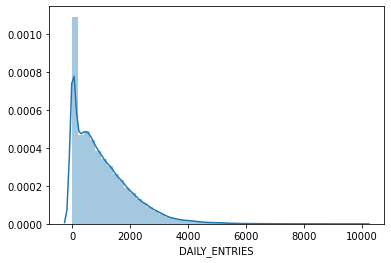

In [19]:
import seaborn as sns

sns.distplot(turnstiles_daily.DAILY_ENTRIES)

In [20]:
mask2 = (turnstiles_daily.DAILY_ENTRIES > 6000)
turnstiles_daily = turnstiles_daily[~mask2]

In [21]:
turnstiles_daily.DAILY_ENTRIES = turnstiles_daily.DAILY_ENTRIES.astype(int)
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,05/12/2019,7054669,05/11/2019,7054133.0,536
2,A002,R051,02-00-00,59 ST,05/13/2019,7055964,05/12/2019,7054669.0,1295
3,A002,R051,02-00-00,59 ST,05/14/2019,7057449,05/13/2019,7055964.0,1485
4,A002,R051,02-00-00,59 ST,05/15/2019,7059011,05/14/2019,7057449.0,1562
5,A002,R051,02-00-00,59 ST,05/16/2019,7060696,05/15/2019,7059011.0,1685
...,...,...,...,...,...,...,...,...,...
203437,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/17/2019,5554,06/16/2019,5554.0,0
203438,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/18/2019,5554,06/17/2019,5554.0,0
203439,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/19/2019,5554,06/18/2019,5554.0,0
203440,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/20/2019,5554,06/19/2019,5554.0,0


In [22]:
turnstiles_daily.DAILY_ENTRIES.describe()

count    198047.000000
mean       1045.580615
std         983.224000
min           0.000000
25%         269.000000
50%         802.000000
75%        1567.000000
max        5991.000000
Name: DAILY_ENTRIES, dtype: float64

In [23]:
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,05/12/2019,7054669,05/11/2019,7054133.0,536
2,A002,R051,02-00-00,59 ST,05/13/2019,7055964,05/12/2019,7054669.0,1295
3,A002,R051,02-00-00,59 ST,05/14/2019,7057449,05/13/2019,7055964.0,1485
4,A002,R051,02-00-00,59 ST,05/15/2019,7059011,05/14/2019,7057449.0,1562
5,A002,R051,02-00-00,59 ST,05/16/2019,7060696,05/15/2019,7059011.0,1685
...,...,...,...,...,...,...,...,...,...
203437,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/17/2019,5554,06/16/2019,5554.0,0
203438,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/18/2019,5554,06/17/2019,5554.0,0
203439,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/19/2019,5554,06/18/2019,5554.0,0
203440,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/20/2019,5554,06/19/2019,5554.0,0


In [24]:
turnstiles_daily.groupby(['STATION']).DAILY_ENTRIES.sum().sort_values(ascending=False)

STATION
34 ST-PENN STA     6095697
34 ST-HERALD SQ    4531066
23 ST              4113105
42 ST-PORT AUTH    3879506
TIMES SQ-42 ST     3742222
                    ...   
BEACH 44 ST          25455
BEACH 98 ST          20546
BROAD CHANNEL        11566
BEACH 105 ST         11532
ORCHARD BEACH         1060
Name: DAILY_ENTRIES, Length: 378, dtype: int64

In [25]:
boroughs = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
boroughs

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN


In [26]:
boroughs['Stop Name'] = boroughs['Stop Name'].str.upper()

In [27]:
boroughs

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,ASTORIA - DITMARS BLVD,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,ASTORIA BLVD,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 AV,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,BROADWAY,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 AV,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,517,517,S15,SIR,Staten Island,PRINCE'S BAY,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville
492,518,518,S14,SIR,Staten Island,PLEASANT PLAINS,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville
493,519,519,S13,SIR,Staten Island,RICHMOND VALLEY,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville
494,522,522,S09,SIR,Staten Island,TOTTENVILLE,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN


In [28]:
turnstiles_daily.STATION.unique() in boroughs['Stop Name'].unique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [29]:
boroughs = boroughs.loc[: ,['Stop Name', 'Borough']]

In [30]:
boroughs.columns = ['STATION', 'Borough']

In [31]:
merged_df = turnstiles_daily.merge(right=boroughs, on='STATION', how='left')

In [32]:
merged_df.sort_values(by='DAILY_ENTRIES', ascending=False)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,Borough
57117,H009,R235,00-03-04,BEDFORD AV,05/21/2019,10853576,05/20/2019,10847585.0,5991,Bk
57137,H009,R235,00-03-04,BEDFORD AV,06/14/2019,10975059,06/13/2019,10969071.0,5988,Bk
298642,R513,R093,00-03-02,30 AV,05/15/2019,1233141,05/14/2019,1227153.0,5988,Q
158954,N506,R022,00-05-05,34 ST-HERALD SQ,05/31/2019,929976,05/30/2019,923993.0,5983,NaN
259861,R240,R047,00-03-08,GRD CNTRL-42 ST,05/14/2019,38370928,05/13/2019,38364953.0,5975,NaN
...,...,...,...,...,...,...,...,...,...,...
38484,C009,R057,03-05-01,ATL AV-BARCLAY,06/14/2019,761,06/13/2019,761.0,0,NaN
38485,C009,R057,03-05-01,ATL AV-BARCLAY,06/15/2019,761,06/14/2019,761.0,0,NaN
38486,C009,R057,03-05-01,ATL AV-BARCLAY,06/16/2019,761,06/15/2019,761.0,0,NaN
38487,C009,R057,03-05-01,ATL AV-BARCLAY,06/17/2019,761,06/16/2019,761.0,0,NaN


In [33]:
'34 ST-HERALD SQ' in boroughs.STATION.unique()

False

In [34]:
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,05/12/2019,7054669,05/11/2019,7054133.0,536
2,A002,R051,02-00-00,59 ST,05/13/2019,7055964,05/12/2019,7054669.0,1295
3,A002,R051,02-00-00,59 ST,05/14/2019,7057449,05/13/2019,7055964.0,1485
4,A002,R051,02-00-00,59 ST,05/15/2019,7059011,05/14/2019,7057449.0,1562
5,A002,R051,02-00-00,59 ST,05/16/2019,7060696,05/15/2019,7059011.0,1685
...,...,...,...,...,...,...,...,...,...
203437,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/17/2019,5554,06/16/2019,5554.0,0
203438,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/18/2019,5554,06/17/2019,5554.0,0
203439,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/19/2019,5554,06/18/2019,5554.0,0
203440,TRAM2,R469,00-05-01,RIT-ROOSEVELT,06/20/2019,5554,06/19/2019,5554.0,0


In [35]:
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily['DATE'])
turnstiles_daily['DAY'] = turnstiles_daily['DATE'].dt.dayofweek
turnstiles_daily['DATE'].dt.week
turnstiles_daily['WEEK_NUMBER'] = turnstiles_daily['DATE'].dt.week


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set(style='white', palette='colorblind')


In [37]:
filt = (turnstiles_daily['STATION'] == '34 ST-PENN STA')
station_penn = turnstiles_daily[filt]
station_penn_day = station_penn.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_penn_list = []
for elem in station_penn_day['DAILY_ENTRIES']:
    station_penn_list.append(elem)

In [38]:
filt2 = (turnstiles_daily['STATION'] == '34 ST-HERALD SQ')
station_herald = turnstiles_daily[filt2]
station_herald_day = station_herald.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_herald_list = []
for elem in station_herald_day['DAILY_ENTRIES']:
    station_herald_list.append(elem)

In [39]:
filt3 = (turnstiles_daily['STATION'] == '23 ST')
station_23 = turnstiles_daily[filt3]
station_23_day = station_23.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_23_list = []
for elem in station_23_day['DAILY_ENTRIES']:
    station_23_list.append(elem)

In [40]:
filt4 = (turnstiles_daily['STATION'] == '42 ST-PORT AUTH')
station_port = turnstiles_daily[filt4]
station_port_day = station_port.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_port_list = []
for elem in station_port_day['DAILY_ENTRIES']:
    station_port_list.append(elem)

In [41]:
filt5 = (turnstiles_daily['STATION'] == 'TIMES SQ-42 ST')
station_times = turnstiles_daily[filt5]
station_times_day = station_times.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_times_list = []
for elem in station_times_day['DAILY_ENTRIES']:
    station_times_list.append(elem)

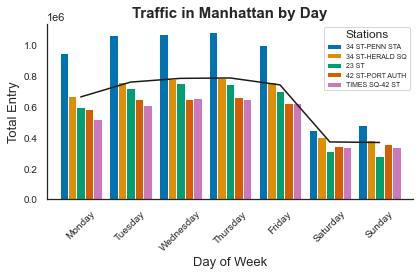

In [42]:
#manhattan bar graph
plotdata = pd.DataFrame({
    "34 ST-PENN STA":station_penn_list,
    "34 ST-HERALD SQ":station_herald_list,
    "23 ST":station_23_list,
    "42 ST-PORT AUTH":station_port_list,
    "TIMES SQ-42 ST":station_times_list
    }, 
    index=["Monday", 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plotdata.plot(kind="bar", width=.85)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.xlabel('Day of Week', fontsize=13)
plt.ylabel('Total Entry', fontsize=13)
plt.title('Traffic in Manhattan by Day', fontsize=15, weight='bold')
plt.legend(loc='upper right', prop={'size': 7}, fancybox=True, title='Stations')
plt.tight_layout()
sns.despine()

#line graph for average across stations per day    
plotdata['mean'] = plotdata.mean(axis=1)
mean_list = []
for elem in plotdata['mean']:
    mean_list.append(elem)
plt.plot(mean_list,'k');
    
# manhattan top 5 stations by volume
# 1. 34 ST-PENN STA
# 2. 34 ST-HERALD SQ
# 3. 23 ST
# 4. 42 ST-PORT AUTH
# 5. TIMES SQ-42 ST

# plt.savefig('Manhattan_Weekly.png', dpi=1200)

In [43]:
filt6 = (turnstiles_daily['STATION'] == '59 ST')
station_59 = turnstiles_daily[filt6]
station_59_day = station_59.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_59_list = []
for elem in station_59_day['DAILY_ENTRIES']:
    station_59_list.append(elem)

In [44]:
filt7 = (turnstiles_daily['STATION'] == 'ATL AV-BARCLAY')
station_atl = turnstiles_daily[filt7]
station_atl_day = station_atl.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_atl_list = []
for elem in station_atl_day['DAILY_ENTRIES']:
    station_atl_list.append(elem)

In [45]:
filt8 = (turnstiles_daily['STATION'] == 'JAY ST-METROTEC')
station_jay = turnstiles_daily[filt8]
station_jay_day = station_jay.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_jay_list = []
for elem in station_jay_day['DAILY_ENTRIES']:
    station_jay_list.append(elem)

In [46]:
filt9 = (turnstiles_daily['STATION'] == 'CHURCH AV')
station_church = turnstiles_daily[filt9]
station_church_day = station_church.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_church_list = []
for elem in station_church_day['DAILY_ENTRIES']:
    station_church_list.append(elem)

In [47]:
filt10 = (turnstiles_daily['STATION'] == 'BOROUGH HALL')
station_borough = turnstiles_daily[filt10]
station_borough_day = station_borough.groupby(['STATION','DAY']).DAILY_ENTRIES.sum().reset_index()
station_borough_list = []
for elem in station_borough_day['DAILY_ENTRIES']:
    station_borough_list.append(elem)

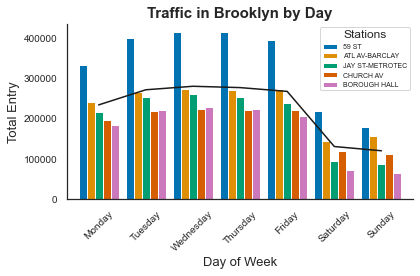

In [48]:
#brooklyn bar graph
plotdata2 = pd.DataFrame({
    "59 ST":station_59_list,
    "ATL AV-BARCLAY":station_atl_list,
    "JAY ST-METROTEC":station_jay_list,
    "CHURCH AV":station_church_list,
    "BOROUGH HALL":station_borough_list
    }, 
    index=["Monday", 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plotdata2.plot(kind="bar", width=.85)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.xlabel('Day of Week', fontsize=13)
plt.ylabel('Total Entry', fontsize=13)
plt.title('Traffic in Brooklyn by Day', fontsize=15, weight='bold')
plt.legend(loc='upper right', prop={'size': 7}, fancybox=True, title='Stations')
sns.despine()
plt.tight_layout()

#line graph for average across stations per day
plotdata2['mean'] = plotdata2.mean(axis=1)
mean_list = []
for elem in plotdata2['mean']:
    mean_list.append(elem)
plt.plot(mean_list,'k');

# brooklyn top 5 stations by volume
# 1. 59 ST
# 2. ATL AV-BARCLAY
# 3. JAY ST-METROTEC
# 4. CHURCH AV
# 5. BOROUGH HALL

# plt.savefig('Brooklyn_Weekly.png', dpi=1200)

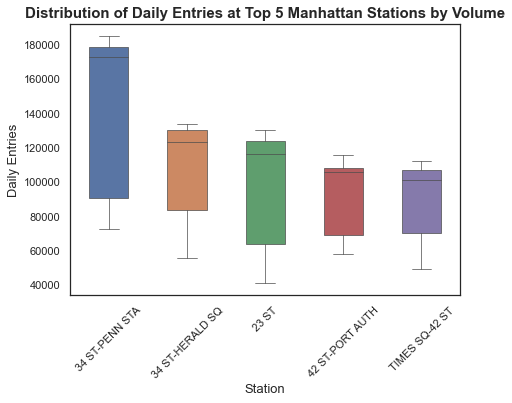

In [50]:
#data for top 5 stations by volume in Manhattan
stations = turnstiles_daily.groupby(['STATION', 'DATE'
                                     ]).DAILY_ENTRIES.sum().reset_index()
top_5_manha_stations = (stations.groupby(
    ['STATION'])['DAILY_ENTRIES'].sum().reset_index().sort_values(
        by='DAILY_ENTRIES', ascending=False).STATION.head(5))
distribution_top_5_manha_stations = stations[stations['STATION'].isin(top_5_manha_stations)]

#boxplot for top 5 stations by volume in Manhattan
plt.figure(figsize=(7, 5))
b = sns.boxplot('STATION', 'DAILY_ENTRIES',
                data=distribution_top_5_manha_stations,
                width=0.5,
                linewidth=0.7,
                palette='deep',
                order=["34 ST-PENN STA", "34 ST-HERALD SQ", "23 ST", '42 ST-PORT AUTH', 'TIMES SQ-42 ST'])
b.set_ylabel('Daily Entries', fontsize=13)
b.set_xlabel('Station', fontsize=13)
b.axes.set_title(
    'Distribution of Daily Entries at Top 5 Manhattan Stations by Volume',
    fontsize=15,
    weight='bold')
b.set_xticklabels(b.get_xticklabels(),rotation=45);

# manhattan top 5 stations by volume
# 1. 34 ST-PENN STA
# 2. 34 ST-HERALD SQ
# 3. 23 ST
# 4. 42 ST-PORT AUTH
# 5. TIMES SQ-42 ST

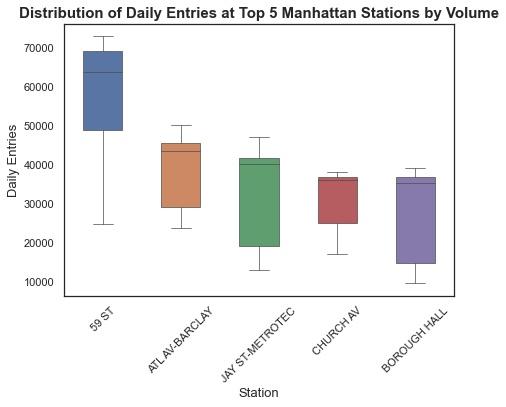

In [52]:
#data for top 5 stations by volume in Brooklyn
top_5_brook_stations = ['59 ST','ATL AV-BARCLAY','JAY ST-METROTEC', 'CHURCH AV','BOROUGH HALL']
distribution_top_5_brook_stations = stations[stations['STATION'].isin(top_5_brook_stations)]

#boxplot for top 5 stations by volume in Brooklyn
plt.figure(figsize=(7, 5))
b = sns.boxplot('STATION', 'DAILY_ENTRIES',
                data=distribution_top_5_brook_stations,
                width=0.5,
                linewidth=0.7,
                palette='deep',
                order=['59 ST','ATL AV-BARCLAY','JAY ST-METROTEC', 'CHURCH AV','BOROUGH HALL'])
b.set_ylabel('Daily Entries', fontsize=13)
b.set_xlabel('Station', fontsize=13)
b.axes.set_title(
    'Distribution of Daily Entries at Top 5 Manhattan Stations by Volume',
    fontsize=15,
    weight='bold')
b.set_xticklabels(b.get_xticklabels(),rotation=45);


# brooklyn top 5 stations by volume
# 1. 59 ST
# 2. ATL AV-BARCLAY
# 3. JAY ST-METROTEC
# 4. CHURCH AV
# 5. BOROUGH HALL

In [54]:
riders_perstation = stations.groupby(['STATION']).DAILY_ENTRIES.sum()
sorted_riders_perstation = riders_perstation.sort_values(ascending=False)

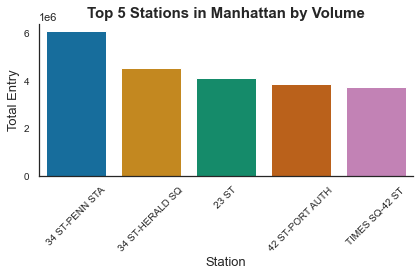

In [55]:
#bar plot data for top 5 stations in Manhattan
manha_top_totals = sorted_riders_perstation.head(5)
man = manha_top_totals.reset_index()
ax = sns.barplot(x="STATION", y="DAILY_ENTRIES", data=man)

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.xlabel('Station', fontsize=13)
plt.ylabel('Total Entry', fontsize=13)
plt.title('Top 5 Stations in Manhattan by Volume', fontsize=15, weight='bold')
sns.despine()
plt.tight_layout()

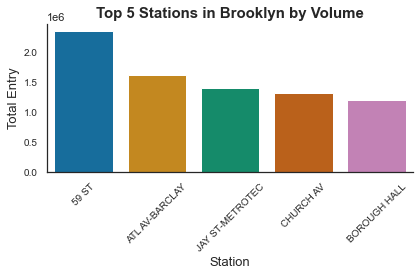

In [77]:
#bar plot data for top 5 stations in Brooklyn
sorted_stations_total = sorted_riders_perstation.reset_index()
filt = sorted_stations_total['STATION'].isin(top_5_brook_stations)
brook_top_totals = sorted_stations_total[filt]
brook = brook_top_totals.reset_index()
ax = sns.barplot(x="STATION", y="DAILY_ENTRIES", data=brook)

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.xlabel('Station', fontsize=13)
plt.ylabel('Total Entry', fontsize=13)
plt.title('Top 5 Stations in Brooklyn by Volume', fontsize=15, weight='bold')
sns.despine()
plt.tight_layout()